# Regularized Linear Regression

In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some **diagnostics of debugging learning algorithms** and examine the **effects of bias v.s. variance.**<br><br>
In the following parts, you will implement linear regression and use that to fit a **straight line** to the data and plot learning curves. Following that, you will implement **polynomial regression** to find a **better fit** to the data.

The file <strong><em>ex5data1</em></strong> contains a data set which includes train set, test set, validation set.<br>
The structure of the dataset described blow:<br>
1. x = **Water level (a single feature)**
2. y = **Value of flowed water**
3. xval = **x validation set**
4. yval = **y validation set**
5. xtest = **x test set**
6. ytest = **y test set**


<br><br>
<strong>
Our assignment has these sections:
1. Visualizing the Data
    1. Converting .mat to .csv
    2. Loading Dataset
    3. Visualizing The Dataset
2. Regularized Linear Regression Cost Function
    1. Implementation
    2. Test Cost Function
3. Regularized Linear Regression Gradient
    1. Implementation
    2. Test Gradient Function
4. Fitting Linear Regression
    1. Implementation
    2. Visualziation of Fitted Model
5. Bias-variance
    1. Learning Curves
    2. Ploting Learning Curve
    
</strong>

In each section full description provided.

## 1. Visualizing the Dataset
Before starting on any task, it is often useful to understand the data by visualizing it.<br>

### 1.A Converting .mat to .csv
In this specific assignment, the instructor added a .mat file as training set and weights of trained neural network. But we have to convert it to .csv to use in python.<br>
After all we now ready to import our new csv files to pandas dataframes and do preprocessing on it and make it ready for next steps.

In [1]:
# import libraries
import scipy.io
import numpy as np

data = scipy.io.loadmat("ex5data1")

Now we **extract** `x`, `y`, `xval`, `yval`, `xtest` and `ytest`</strong> variables from the .mat file and save them into .csv file for further usage. After running the below code you should see:
1. X.csv
2. y.csv 
3. Xtest.csv
4. ytest.csv
5. Xval.csv
6. yval.csv

files in your directory.

In [2]:
for i in data:
    if '__' not in i and 'readme' not in i:
        np.savetxt((i+".csv"),data[i],delimiter=',')

### 1.B Loading Dataset
First we import .csv files into pandas dataframes then save them into numpy arrays.<br><br>

In [3]:
# import library
import pandas as pd

# saving .csv files to pandas dataframes
x_df = pd.read_csv('X.csv',names= ['x'])
xtest_df = pd.read_csv('Xtest.csv',names= ['xtest'])
xval_df = pd.read_csv('Xval.csv',names= ['xval'])
y_df = pd.read_csv('y.csv',names=['y'])
ytest_df = pd.read_csv('ytest.csv',names= ['ytest'])
yval_df = pd.read_csv('yval.csv',names= ['yval'])

In [4]:
x_df.head(3)

,x
0,-15.936758
1,-29.152979
2,36.189549


In [5]:
y_df.head(3)

,y
0,2.134311
1,1.173257
2,34.359109


Now we convert all **pandas dataframes** to **numpy arrays** for calculations.

In [6]:
# saving x, y, xval, yval, xtest and ytest into numpy arrays
x = x_df.iloc[:,:].values
xval = xval_df.iloc[:,:].values
xtest = xtest_df.iloc[:,:].values

y = y_df.iloc[:,:].values
yval = yval_df.iloc[:,:].values
ytest = ytest_df.iloc[:,:].values

# number of examples and number of features
m, n = x.shape

# add 1's to the features of x as bias
x = np.append(np.ones(shape=(m,1)),x,axis = 1)
xval = np.append(np.ones(shape=(xval.shape[0],1)),xval,axis = 1)
xtest = np.append(np.ones(shape=(xtest.shape[0],1)),xtest,axis = 1)



m_val = xval.shape[0]
m_test = xtest.shape[0]

print('#{} Number of training samples, #{} features per sample'.format(m,n))
print('#{} Number of validation samples, #{} features per sample'.format(m_val,n))
print('#{} Number of test samples, #{} features per sample'.format(m_test,n))

#12 Number of training samples, #1 features per sample
#21 Number of validation samples, #1 features per sample
#21 Number of test samples, #1 features per sample


In [7]:
# define some hypter parameters

# define theta as zero
theta = None

# define hyperparameter λ
lambda_ = None

# reshape (-1,1) because we just have one feature in y column
y = y.reshape(-1,1)

### 1.C Ploting Dataset
We will begin by visualizing the dataset containing historical records on **the change in the water level**, `x`, and **the amount of water flowing out of the dam**, `y`.<br><br>
This dataset is divided into three parts:<br>
    • A **training set** that your model will learn on: `x`, `y`<br>
    • A **cross validation set** for determining the regularization parameter: `xval`, `yval`<br>
    • A **test set** for evaluating performance. These are **"unseen" examples** which your model did not see during training: `xtest`, `ytest`<br>

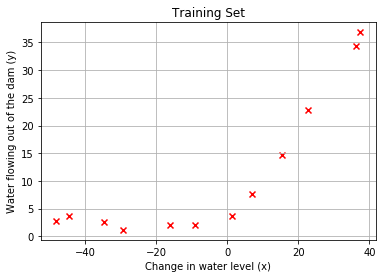

In [8]:
# import libraries
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(x[:,1], y, color='red', marker='x')
plt.title('Training Set')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.grid()
plt.show()

# 2 Regularized Linear Regression Cost Function
Recall that regularized linear regression has the following cost function:<img src='img/rlrc.jpg'><br><br>
where `lambda` is a regularization parameter which controls the degree of regularization (thus, **help preventing overfitting**). The **regularization** term puts a **penalty** on the overal **cost J**.<br><br>
As the magnitudes of the model parameters **θ<sub>j</sub>**
increase, the penalty increases as well. Note that you should not regularize the **θ<sub>0</sub>** term.<br><br>

**Your task is to write a function to calculate the regularized linear regression cost function. If possible, try to vectorize your code and avoid writing loops.**

# 2.A Implementation
`linear_reg_cost(x, y, theta, lambda_)` computes the cost of using `theta` as the parameter for linear regression to fit the data points in `x` and `y`. Returns the cost in `j` as cost.

In [9]:
def hypothesis(x,theta):
    return np.dot(x,theta)

In [10]:
def linear_reg_cost(theta_flatten, x_flatten, y, lambda_, num_of_samples, num_of_features):
    x = x_flatten.reshape(num_of_samples, num_of_features)
    theta = theta_flatten.reshape(n,1)
    loss = hypothesis(x,theta)-y
    regularizer = lambda_*np.sum(theta[1:,:]**2)/(2*m)
    j = np.sum(loss ** 2)/(2*m) 
    return j

## 2.B Test Cost Function
Cost at `theta` = [1,1] should be about **303.993192**

In [11]:
m,n = x.shape
theta = np.ones(n)
lambda_= 1
linear_reg_cost(theta.flatten(), x.flatten(),y,lambda_,m,n)

303.95152555359761

<strong>compute_gradient(theta, x, y,lambda):</strong> computes the gradient of the cost using theta as the parameter.

# 3. Regularized Linear Regression Gradient
Correspondingly, the **partial derivative of regularized linear regression’s cost for θ<sub>j</sub>** is defined as:<img src='img/rlrg.jpg'>

## 3.A Implementation

`linear_reg_grad(x, y, theta, lambda_)` computes the gradient of cost of using `theta` as the parameter for linear regression to fit the data points in `x` and `y`. Returns the gradient in `grad`.

In [12]:
def linear_reg_grad(theta_flatten, x_flatten, y, lambda_, num_of_samples, num_of_features):
    x = x_flatten.reshape(num_of_samples, num_of_features)
    m,n = x.shape
    theta = theta_flatten.reshape(n,1)
    new_theta = np.zeros(shape=(theta.shape))
    loss = hypothesis(x,theta)-y
    gradient = np.dot(x.T,loss)
    new_theta[0:,:] = gradient/m
    new_theta[1:,:] = gradient[1:,:]/m + lambda_*(theta[1:,]/m)
    return new_theta.flatten()

## 3.B Test Gradient Function
Run your gradient function using `theta = [1; 1]`, You should expect to see a `gradient = [-15.30; 598.250]`.

In [13]:
theta = np.ones(n)
lambda_ = 0
grad = linear_reg_grad(theta,x.flatten(),y,lambda_,m,n)

In [14]:
grad

array([ -15.30301567,  598.16741084])

# 4. Fitting Linear Regression
Once your cost function and gradient are working correctly, the next part is to **compute the optimal values** of **θ**.<br>
This training function uses `fmin_cg` to optimize the cost function. <a href='https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.fmin_cg.html'>See official doc</a><br>
In this part, we set regularization parameter **λ** to **zero**. Because our current implementation of linear regression is trying to fit a 2-dimensional **θ**, regularization will not be incredibly helpful for a **θ** of such **low dimension**.<br>
In the later parts of the exercise, you will be using **polynomial regression with regularization**.

## 4.A Implementation
Once you have implemented the cost and gradient correctly, the `fmin_cg` function will use your cost function to train regularized linear regression and update theta each time.

In [15]:
theta = np.ones(n)

from scipy.optimize import fmin_cg
new_theta = fmin_cg(f=linear_reg_cost, x0=theta, fprime=linear_reg_grad, args=(x.flatten(), y, lambda_, m,n))

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


In [16]:
new_theta

array([ 13.08790734,   0.36777925])

## 4.B Visualization of Fitted Model
Finally, you should also **plot the best fit line**. The best fit line tells us that the model is not a good fit to the data because the **data has a non-linear pattern**. While **visualizing the best fit** as shown is **one possible way to debug** your learning algorithm, it is not always easy to visualize the data and model.<br><br>
In the next section, you will implement a function to **generate learning curves** that can help you debug your learning algorithm even if it is **not easy to visualize** the data.

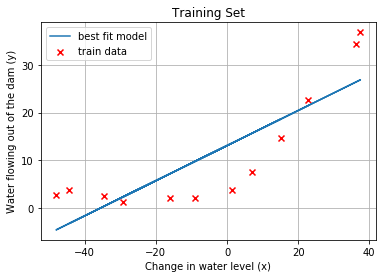

In [17]:
# import libraries
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(x[:,1], y, color='red', marker='x', label= 'train data')
plt.plot(x[:,1],np.dot(x,new_theta.reshape(n,1)), label = 'best fit model')
plt.title('Training Set')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.grid()
plt.legend()
plt.show()

# 5. Bias-Variance
An important concept in machine learning is the **bias-variance tradeoff**. Models with **high bias** are not complex enough for the data and tend to **underfit**, while models with **high variance** **overfit** to the training data.<br>
In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

## 5.1 Learning Curves
You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve **plots training and cross validation error as a function of training set size.**<br>
To plot the learning curve, we need a training and cross validation set error for **different training set** sizes. To obtain different training set sizes, you should use **different subsets** of the original training set `x`. Specifically, for a training set size of `i`, **you should use the first `i` examples **(i.e., `X[1:i,:]` and `y[1:i]`).<br><br>
You can use the `fmin_cg` function to find the `θ` parameters. Note that the `lambda` is passed as a parameter to the `learning_curve` function. After learning the `θ` parameters, you should **compute the error on the training and cross validation sets.** Recall that the **training error** for a dataset is defined as:<img src='img/jtrain.jpg'><br>

In particular, note that the **training error does not include the regularization** term. One way to compute the training error is to **use your existing cost function and set `λ` to `0`** only when using it to compute the training error and cross validation error.<br>
When you are **computing the training set error**, make sure you compute it on the **training subset (i.e., `x[1:n,:]` and `y[1:n]`)** (instead of the entire training set). However, for the **cross validation error**, you should compute it over the **entire cross validation set**. You should store the computed errors in the vectors `error_train` and `error_val`.

`learning_curve(x, y, xval, yval, lambda_)` **returns the train and cross validation set errors for a learning curve**.<br><br> In particular, it returns two vectors of the same length - `error_train` and `error_val`. Then, `error_train[i]` contains the training error for `i` examples (and similarly for `error_val[i]`).

In [18]:
error_train = np.zeros(m)
error_val = np.zeros(m)

lambda_ = 1

In [38]:
def train_val_error(x, y, xval, yval, lambda_):
    m,n = x.shape
    theta = np.ones(n) # initialize theta for each time of training with subset of training set.
    new_theta = fmin_cg(f=linear_reg_cost, x0=theta, fprime=linear_reg_grad, args=(x.flatten(), y, lambda_, m,n))
    t_error = linear_reg_cost(new_theta.flatten(), x.flatten(), y, 0, x.shape[0], x.shape[1])
    v_error = linear_reg_cost(new_theta.flatten(), xval.flatten(), yval, 0, xval.shape[0], xval.shape[1])
    return (t_error, v_error)

In [39]:
def learning_curve(x, y, xval, yval, lambda_):
    m,n = x.shape
    et_array = np.zeros(m)
    ev_array = np.zeros(m)
    for i in range(1,m):
        et_array[i] , ev_array[i] = train_val_error(x[0:i,:],y[0:i],xval,yval,lambda_)
    return (et_array,ev_array)

In [56]:
error_train, error_val = learning_curve(x,y,xval,yval,lambda_,)

         Current function value: 0.000001
         Iterations: 7
         Function evaluations: 145
         Gradient evaluations: 133
         Current function value: 0.000001
         Iterations: 11
         Function evaluations: 130
         Gradient evaluations: 118
         Current function value: 0.821654
         Iterations: 12
         Function evaluations: 133
         Gradient evaluations: 118
         Current function value: 0.947566
         Iterations: 12
         Function evaluations: 89
         Gradient evaluations: 76
         Current function value: 5.480855
         Iterations: 10
         Function evaluations: 135
         Gradient evaluations: 123
         Current function value: 9.721983
         Iterations: 15
         Function evaluations: 130
         Gradient evaluations: 118
         Current function value: 11.724155
         Iterations: 13
         Function evaluations: 132
         Gradient evaluations: 118
         Current function value: 12.115397
       

## 5.2 Ploting Learning Curve
You must observe that both the **train error and cross validation error are high** when the number of **training examples** is **increased**. This reflects a **high bias** problem in the model. (the **linear regression** model is too simple and is unable to fit our dataset well so it is **underfitting**)

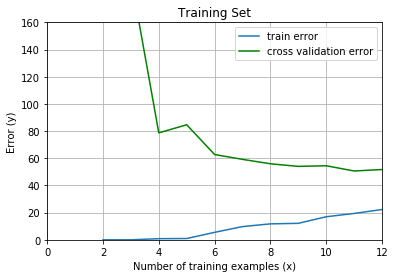

In [74]:
plt.plot(np.arange(2,m+1),error_train[1:], label = 'train error')
plt.plot(np.arange(2,m+1),error_val[1:], label = 'cross validation error', color= 'green')
plt.axis([0, 12, 0, 160])
plt.title('Training Set')
plt.xlabel('Number of training examples (x)')
plt.ylabel('Error (y)')
plt.grid()
plt.legend()
plt.show()

In the next section, you will implement **polynomial regression** to fit a better model for this dataset.